### Import

In [21]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

### Load Data

In [22]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

### Functions

In [23]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('knn__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))
        ])

        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

### KNN with MinMaxScaler

In [29]:
random_seed = 17
pipe_knn = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]

)

search_grid = {
    'knn__n_neighbors': [i for i in range(2, 101)],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [i for i in range(1,4)], 
    'knn__leaf_size': [i for i in range(1, 51, 1)], 
    'knn__n_jobs': [-1]
}

In [30]:
%%time

knn_opt_results_rs = tune_with_random_search(pipe_knn, search_grid,100, 'roc_auc')

CPU times: user 1.47 s, sys: 870 ms, total: 2.34 s
Wall time: 31.6 s


In [8]:
save_result(knn_opt_results_rs,'./saved_results/knn_opt_results_rs.pkl')

In [34]:
knn_opt_results_rs=load_result('./saved_results/knn_opt_results_rs.pkl')

In [35]:
for i in range(4):
    print(knn_opt_results_rs[i].best_params_)

{'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 98, 'knn__n_jobs': -1, 'knn__leaf_size': 50}
{'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 26, 'knn__n_jobs': -1, 'knn__leaf_size': 27}
{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 95, 'knn__n_jobs': -1, 'knn__leaf_size': 26}
{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 64, 'knn__n_jobs': -1, 'knn__leaf_size': 26}


In [7]:
knn_tunabilities_rs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_rs, 'roc_auc')
knn_tunabilities_rs

[0.0561924871546583,
 0.02890123456790128,
 0.15369068131396457,
 0.03932367416765359]

### Bayes

In [9]:
pipe_knn = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]

)

search_grid = {
    'knn__n_neighbors': Integer(2, 100),
    'knn__weights': Categorical(['uniform', 'distance']), 
    'knn__p': Integer(1,4),
    'knn__leaf_size': Integer(1,50),
    'knn__n_jobs': Categorical([-1])
}

In [10]:
%%time

knn_opt_results_bs = tune_with_bayes_search(pipe_knn, search_grid, 100, "roc_auc")

CPU times: user 54min 27s, sys: 44min 56s, total: 1h 39min 24s
Wall time: 13min 4s


In [12]:
save_result(knn_opt_results_bs,'./saved_results/knn_opt_results_bs.pkl')

In [32]:
knn_opt_results_bs=load_result('./saved_results/knn_opt_results_bs.pkl')

In [33]:
for i in range(4):
    print(knn_opt_results_bs[i].best_params_)

OrderedDict([('knn__leaf_size', 50), ('knn__n_jobs', -1), ('knn__n_neighbors', 98), ('knn__p', 1), ('knn__weights', 'uniform')])
OrderedDict([('knn__leaf_size', 50), ('knn__n_jobs', -1), ('knn__n_neighbors', 18), ('knn__p', 2), ('knn__weights', 'uniform')])
OrderedDict([('knn__leaf_size', 50), ('knn__n_jobs', -1), ('knn__n_neighbors', 91), ('knn__p', 1), ('knn__weights', 'distance')])
OrderedDict([('knn__leaf_size', 1), ('knn__n_jobs', -1), ('knn__n_neighbors', 66), ('knn__p', 1), ('knn__weights', 'distance')])


In [14]:
knn_tunabilities_bs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_bs, 'roc_auc')
knn_tunabilities_bs

[0.0561924871546583,
 0.028851851851851906,
 0.1548315015097934,
 0.03940332675352021]

### Plots

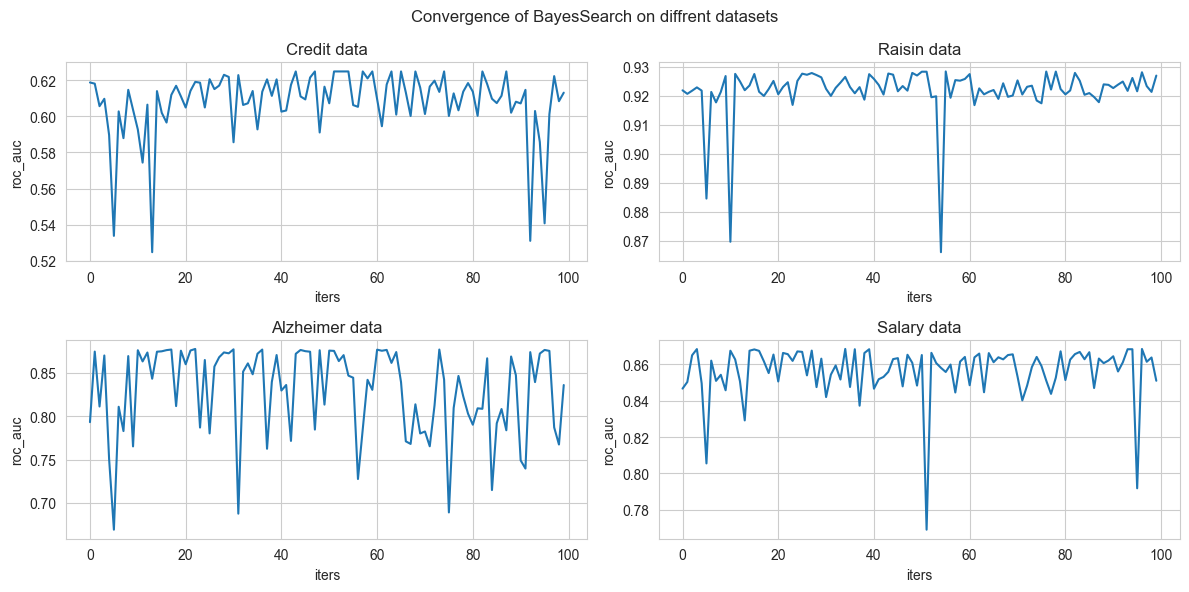

In [15]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(knn_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

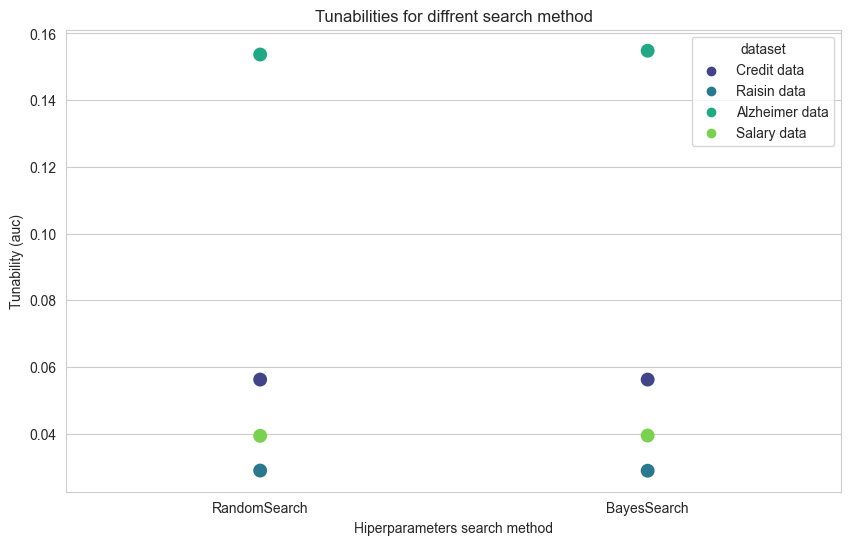

In [18]:
data = {
    'tunability': knn_tunabilities_rs + knn_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

In [19]:
default_score = get_deafult_score(KNeighborsClassifier, {'n_jobs': -1}, 'roc_auc')
default_score

[0.5688120450455976,
 0.8995679012345679,
 0.7229566270980936,
 0.8291489248585341]

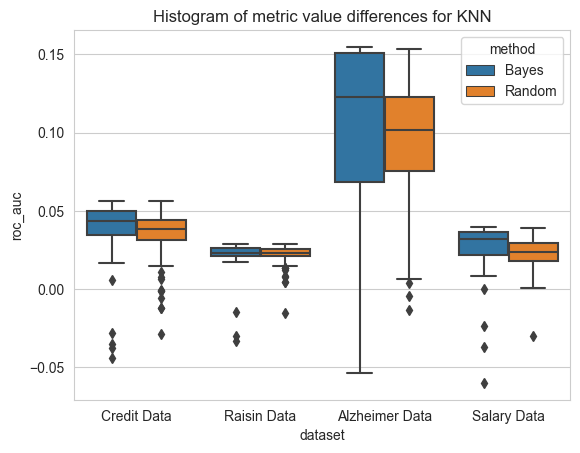

In [20]:
data = {
    'Credit Data': knn_opt_results_bs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': knn_opt_results_bs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': knn_opt_results_bs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': knn_opt_results_bs[3].cv_results_["mean_test_score"]-default_score[3]
}
data_random = {
    'Credit Data': knn_opt_results_rs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': knn_opt_results_rs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': knn_opt_results_rs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': knn_opt_results_rs[3].cv_results_["mean_test_score"]-default_score[3]
}
data = pd.DataFrame(data)
data_random = pd.DataFrame(data_random)
# connect datasets data and data_random, adding column with method Random and Bayes 
data['method'] = 'Bayes'
data_random['method'] = 'Random'
data = pd.concat([data, data_random])
data = data.melt(id_vars='method', var_name='dataset', value_name='roc_auc')

sns.boxplot(x='dataset', y='roc_auc', hue='method', data=data)
plt.title('Histogram of metric value differences for KNN')
plt.show()